In [4]:
#!/usr/bin/env python
# coding: utf-8

Test Machine Learning algorithms

In [5]:
# Import librairies
import os
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import shutil
import sys
import warnings

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import hamming_loss, confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline,  make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.svm import LinearSVC, SVC

from skmultilearn.adapt import MLkNN
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance, LabelPowerset

from scipy.sparse import csr_matrix, lil_matrix
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer

from utils_text_processing import *
from utils_visualization import *
from utils_metrics import *

2023-05-22 20:27:28.291462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 20:27:28.720960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-22 20:27:29.162812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 20:27:29.163131: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

In [6]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [7]:
# Parametres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': False,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})
pd.set_option('display.max_columns', None)

In [8]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figs"

In [9]:
# Input data
working_data_filename = "working_data_sans_dewey_processed.pkl"


In [10]:
# Import data
df = pd.read_pickle(os.path.join(data_path, working_data_filename))
print(f"le Fichier de données contient {df.shape[0]} lignes et  {df.shape[1]} colonnes")

le Fichier de données contient 154508 lignes et  10 colonnes


In [11]:
# label encoding
def encoding(df, corpus, col_label):
    df_encoded = df.copy()

    # define X and y
    X = df_encoded[corpus]
    y = df_encoded[col_label]

    # encode labels
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y)
    classes = mlb.classes_
    return X, y_encoded, classes, mlb

In [12]:
# encode labels
print("Encoding labels for trained dataset")
X, y, classes, mlb = encoding(
    df,
    corpus="DESCR_processed",
    col_label="rameau_concepts")
print("Labels encoded")

Encoding labels for trained dataset
Labels encoded


In [13]:
classes

array(["'Ndrangheta", "'Ūd", "'Ūd, Musique d'", ..., 'éthique',
       'Čech, Cohomologie de', 'Ōmoto (secte)'], dtype=object)

## Split dataset

### Get validation data

In [14]:
# Validation data : 100 re-indexed notices
reindexed = pd.read_excel(os.path.join(data_path, "reindexation/avril2023/100 NOTICES A INDEXER.xlsx"), converters={"PPN": str})
reindexed = reindexed.drop(index=reindexed[reindexed["PPN"].isnull()].index)
reindexed

,N°ordre,PPN,TITRE,RESUME,INDEXATION UNIMARC,INDEXATION AFFICHAGE PUBLIC
0,79,308838,Les sommets de l'État : essai sur l'élite du p...,"Du XIXe siècle à nos jours, l'Etat ""fort"" à la...",NaN,NaN
1,58,3632806,Les intellectuels sous la Ve République : 1958...,"Célèbres, influents, on les voit, on en parle ...",NaN,NaN
2,59,47450037,"Bouddha, bouddhisme","La 4e de couv. indique : ""Ce petit livre répon...",NaN,NaN
3,65,58296182,L'homme devant l'incertain,"La quatrième de couverture indique : ""Réintrod...",NaN,NaN
4,80,59911174,Imperator Caesar Augustus : recherches sur le ...,Ce dossier comporte quatre volumes qui aborden...,NaN,NaN
...,...,...,...,...,...,...
95,38,23690454X,Droit public et patrimoine : le rôle du Consei...,"la 4e de couv. indique : ""L'histoire du droit ...",NaN,NaN
96,95,24155859X,Lars Fredrikson : [exposition Musée d'art mode...,Première grande monographie consacrée à l'œuvr...,NaN,NaN
97,52,25561280X,L'ère des soulèvements : émeutes et confinemen...,"Dès les années 1980, Michel Maffesoli se fait ...",NaN,NaN
98,99,26117309X,Monde enchanté : chansons et imaginaires géogr...,Le monde est enchanté par certaines chansons. ...,NaN,NaN


In [15]:
# Get subset of 100 notices
subset = df.merge(reindexed, on="RESUME", how="inner")
subset.shape

(100, 15)

### Use split performed by Jean Luc Prieto

In [16]:
train_set_ppn = pd.read_excel(os.path.join(data_path, "training_data.xlsx"), dtype=str)
print("dimension of train set: ", train_set_ppn.shape)
test_set_ppn = pd.read_excel(os.path.join(data_path, "testing_data.xlsx"), dtype=str)
print("dimension of test set: ", test_set_ppn.shape)

dimension of train set:  (125264, 1)
dimension of test set:  (29244, 1)


In [17]:
df_train = pd.merge(df, train_set_ppn, on="PPN", how="inner")
print("dimension of train set: ", df_train.shape)
df_test = pd.merge(df, test_set_ppn, on="PPN", how="inner")
print("dimension of test set: ", df_test.shape)

dimension of train set:  (115853, 10)
dimension of test set:  (27070, 10)


In [18]:
# Get X matrices
X_train = df_train["DESCR_processed"]
X_test = df_test["DESCR_processed"]
X_val = subset["DESCR_processed"]

In [19]:
# encode labels
print("Encoding labels for trained dataset")
y_train = mlb.transform(df_train["rameau_concepts"])
print("Labels encoded", y_train.shape)

print("Encoding labels for test dataset")
y_test = mlb.transform(df_test["rameau_concepts"])
print("Labels encoded", y_test.shape)

print("Encoding labels for validation dataset")
y_val = mlb.transform(subset["rameau_concepts"])
print("Labels encoded", y_val.shape)

Encoding labels for trained dataset
Labels encoded (115853, 26642)
Encoding labels for test dataset
Labels encoded (27070, 26642)
Encoding labels for validation dataset
Labels encoded (100, 26642)


In [20]:
print(X_train.shape, X_test.shape, X_val.shape)

(115853,) (27070,) (100,)


In [21]:
X_train

0         politique réunion michel debré élire député ré...
1         aparole électoral 4ème couv indique " somme mo...
2         face cachée soleil énergie solaire architectur...
3         voie vertu tao - tê - king couverture indique ...
4         akavak akavak an pourtant luire revenir respon...
                                ...                        
115848    blablabla finir bavardage climatique brouhaha ...
115849    politique transition écologique démocratie dro...
115850    abécédaire mot rite ailleurs dédier abécédaire...
115851    consommer consommer mieux cahier pratique ludi...
115852    langage perdre plante -vou goûter eau sauvage ...
Name: DESCR_processed, Length: 115853, dtype: object

In [22]:
# Check classes
print("nombre de labels différents: ", len(classes))
classes

nombre de labels différents:  26642


array(["'Ndrangheta", "'Ūd", "'Ūd, Musique d'", ..., 'éthique',
       'Čech, Cohomologie de', 'Ōmoto (secte)'], dtype=object)

In [23]:
# Check size of test and train datasets
print(f"Train dataset size : {len(y_train)}")
print(f"Test dataset size : {len(y_test)}")
print(f"Validation dataset size : {len(y_val)}")


Train dataset size : 115853
Test dataset size : 27070
Validation dataset size : 100


# Check splitting balance
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
order = 3
pd.DataFrame({
    'train': Counter(
        str(combination) for row in get_combination_wise_output_matrix(
            y_train, order=order) for combination in row),
    'test': Counter(
        str(combination) for row in get_combination_wise_output_matrix(
            y_test, order=order) for combination in row)
}).T.fillna(0.0)

## Vectorize dataset (tf-idf)

In [24]:
# Set parameters for tf-idf
max_df = 0.95
min_df = 2
max_features = 500
n_gram = (1, 3)
regex_pattern = r'\w{3,}'

In [25]:
# Build vectorizer
vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    ngram_range=n_gram,
    token_pattern=regex_pattern)

In [24]:
# Vectorize corpus
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
features = vectorizer.get_feature_names_out()

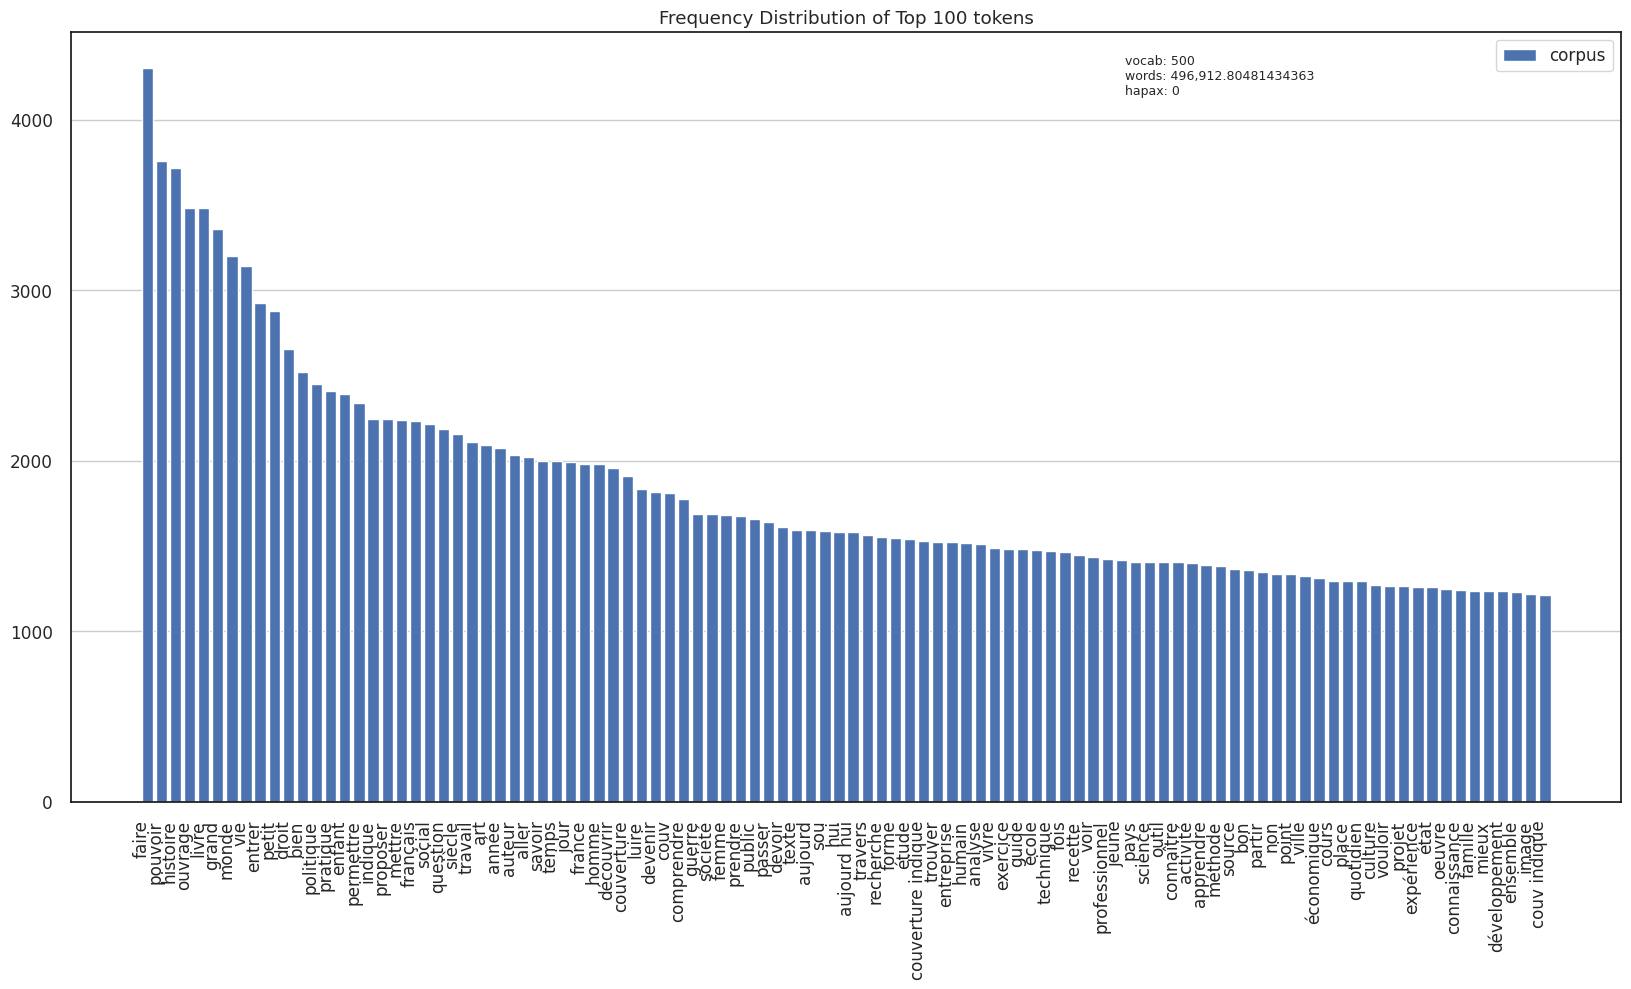

<Axes: title={'center': 'Frequency Distribution of Top 100 tokens'}>

In [25]:
# Visualize Word Frequency Distribution
plt.figure(figsize=(20, 10))
visualizer = FreqDistVisualizer(features=features, n=100, orient="v")
visualizer.fit(X_train_vect)
visualizer.show()

## Basic classification models

In [26]:
# Save model
def save_model_pkl(model, modelname):
    joblib.dump(model, os.path.join(output_path, modelname))

In [27]:
# Training of transformed classifier for multi-label purpose
def classification_model(algo, transf=""):
    if algo == 'lr':
        model = LogisticRegression(
            solver='saga',
            max_iter=500,
            class_weight='balanced')
        require_dense = [False, True]
    elif algo == 'svc':
        model = LinearSVC(
            max_iter=500,
            class_weight='balanced')
        require_dense = [False, True]
    elif algo == 'MultinomialNB':
        model = MultinomialNB()
        require_dense = [False, True]
    elif algo == 'GaussianNB':
        model = GaussianNB()
        require_dense = [True, True]
    elif algo == 'knn':
        model = KNeighborsClassifier(n_neighbors=3)
        require_dense = [False, True]
    elif algo == 'MLkNN':
        model = MLkNN(k=3)
        transf = None
    elif algo == 'rf':
        model = RandomForestClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            max_depth=20,
            n_jobs=-1)
        require_dense = [False, True]
    elif algo == 'tree':
        model = DecisionTreeClassifier()
        require_dense = [False, True]
    elif algo == "bagging":
        model = BaggingClassifier(n_jobs=-1)
        require_dense = [False, True]
    elif algo == "boosting":
        model = GradientBoostingClassifier()
        require_dense = [False, True]
    else:
        print('The algo ' + algo + ' is not defined!')

    if transf == 'BR':
        clf = BinaryRelevance(model, require_dense=require_dense)
    elif transf == 'CC':
        clf = ClassifierChain(model, require_dense=require_dense)
    elif transf == 'LP':
        clf = LabelPowerset(model, require_dense=require_dense)
    elif transf == 'OneVsRest':
        clf = OneVsRestClassifier(model)
    else:
        clf = model

    return clf

In [28]:
# Define models and transformations
model_list = [
    'MultinomialNB',
    'knn', 'GaussianNB', 'tree', 'rf',
    'bagging', 'boosting', 'MLkNN']
transf_list = ["LP"]
ModelsPerformance_test = {}
ModelsPerformance_val = {}

In [30]:
model_list = [
    'tree', 'rf',
    'bagging', 'boosting', 'MLkNN']

In [31]:
# Define pipeline
# Run models
for model in model_list:
    for transf in transf_list:
        print(f"Treating model: {model} adapted with {transf}")
        model_name = str(model + "_" + transf)
        clf = classification_model(
            algo=model,
            transf=transf)
        X_train_vect = vectorizer.fit_transform(X_train)
        clf.fit(X_train_vect, y_train)
        print("model fitted")
        X_test_vect = vectorizer.transform(X_test)
        X_val_vect = vectorizer.transform(X_val)
        predictions_test = clf.predict(X_test_vect)
        predictions_val = clf.predict(X_val_vect)
        print("predictions done")
        print("Computing metrics on test set")
        ModelsPerformance_test[model_name] = label_metrics_report(model, y_test, predictions_test, zero_division="warn", print_metrics=True)
        pd.DataFrame(ModelsPerformance_test).to_csv("MLclassifier_results_test_set.csv")
        print("Computing metrics on validation set")
        ModelsPerformance_val[model_name] = label_metrics_report(model, y_val, predictions_val, zero_division="warn", print_metrics=True)
        pd.DataFrame(ModelsPerformance_val).to_csv("MLclassifier_results_val_set.csv")

Treating model: tree adapted with LP


In [ ]:
model = MultinomialNB()
require_dense = [False, True]

In [ ]:
clf = LabelPowerset(model, require_dense=require_dense)
clf

In [ ]:
clf.fit(X_train_vect, y_train)

In [ ]:
clf.fit()

In [ ]:
X_train_vect

In [ ]:
predictions = clf.predict(X_test_vect)

In [ ]:
y_test.shape

In [ ]:
predictions.shape

In [ ]:
ModelsPerformance["MultinomialNB"] = label_metrics_report("MultinomialNB", y_test, predictions, zero_division="warn", print_metrics=True)
ModelsPerformance        

In [ ]:
pd.DataFrame(ModelsPerformance).to_csv("MLclassifier_results.csv")

In [ ]:
pd.DataFrame(ModelsPerformance).to_csv("MLclassifier_results.csv")

In [ ]:
# Vectorization
vectorizer = TfidfVectorizer(
        max_df=max_df,
        min_df=min_df,
        max_features=max_features,
        ngram_range=n_gram,
        token_pattern= r'\w{3,}')

X_val_vect = vectorizer.transform(X_val)

In [ ]:
# Show performances of a specific model
model_name = "svc_LP"
ModelsPerformance[model_name]

## Models adapted to multi-label classification

### MLKNN

In [ ]:
# MLKNN
model = "MLkNN"
clf = classification_model(
        X_train=X_train_vect,
        y_train=y_train,
        algo=model,
        save=False)
predictions = clf.predict(X_test_vect)
ModelsPerformance[model] = metricsReport(model, y_test, predictions, print_metrics=True)

### MEKA

In [ ]:
# MEKA
from skmultilearn.ext import download_meka
from skmultilearn.ext import Meka

meka_classpath = download_meka()
meka_classpath

In [ ]:
# Model
model = "Meka"
meka = Meka(
        meka_classifier = "meka.classifiers.multilabel.BR", # Binary Relevance
        weka_classifier = "weka.classifiers.bayes.NaiveBayesMultinomial", # with Naive Bayes single-label classifier
        meka_classpath = meka_classpath, #obtained via download_meka
        java_command = '/usr/bin/java' # path to java executable
)
meka

In [ ]:
# Fit and performance
meka.fit(X_train, y_train)
predictions = meka.predict(X_test)
ModelsPerformance[model] = metricsReport(model, y_test, predictions, print_metrics=True)

### Multiclass Keras classifier

In [ ]:
!pip install -U skorch torch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

In [ ]:
# Define model parameters
model= "neural_network"
nodes = 8
input_dim = X_train.shape[1]
hidden_dim = int(input_dim/nodes)
output_dim = len(np.unique(y_train.rows))

In [ ]:
# Create model
class MultiClassClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(MultiClassClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

In [ ]:
net = NeuralNetClassifier(
    MultiClassClassifierModule,
    max_epochs=20,
    verbose=0
)

In [ ]:
# Fit and predict
clf = LabelPowerset(classifier=net, require_dense=[True,True])
clf.fit(X_train.astype(np.float32),y_train)
y_pred = clf.predict(X_test.astype(np.float32))
ModelsPerformance[model] = metricsReport(model, y_test, y_pred, print_metrics=True)

# Visualize performances

In [ ]:
pd.DataFrame(ModelsPerformance)

In [ ]:
# Save performances
pd.DataFrame(ModelsPerformance).to_csv(os.path.join(output_path, "ML_metrics_13042023.csv"), index=False)

## Test on subsamples for metrics understanding

### Test on N samples

In [ ]:
# Define number of samples
n = 20

In [ ]:
# Select 20 samples
X_test_vect_sample = X_test_vect[:n]
y_test_sample = y_test[:n]

In [ ]:
# Recreate labels (vedettes)
y_test_labels_sample = mlb.inverse_transform(y_test_sample)
y_test_labels_sample

In [ ]:
# Run models
ModelsPerformance = {}
for model in model_list:
    print("Treating model: ", model)
    clf = classification_model(
        X_train=X_train_vect,
        y_train=y_train,
        algo=model,
        save=False)
    predictions20 = clf.predict(X_test_vect_20)
    ModelsPerformance[model] = metricsReport(model, y_test_20, predictions20, print_metrics=True)

In [ ]:
# index_test
index_test[:n].tolist()

In [ ]:
# Refind raw data
df.loc[index_test.values]

In [ ]:
# Create dataframe
pd.DataFrame([X_test[:n].values, y_test_labels_sample, labels])